# Image Enhancing using a Convnet

The goal is to take an image with degraded resolution and use a convnet model to output an image with enhanced resolution. To build the training set, a degraded image can be formed by rescaling the image twice. 

### Importing libraries

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D,Conv2DTranspose
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from sklearn.model_selection import train_test_split
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Mounting google drive

In [ ]:
# You can mount your google drive under content
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Files downloading and unzipping. (for first time downloading)

In [ ]:
# Download the dataset
import requests
url='http://mmlab.ie.cuhk.edu.hk/projects/SRCNN/SRCNN_train.zip'
r = requests.get(url,allow_redirects=True)
# Save at a specific location
f = open('/content/gdrive/My Drive/Colab Notebooks/Datasets/SRCNN_train.zip','wb')
f.write(r.content)

19619221

In [ ]:
# unzip everything
import zipfile
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Datasets/SRCNN_train.zip','r') as zip_ref:
  zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Datasets')

### Data preprocessing

In [ ]:
# This cell isn't written very efficiently, so will take a minute

import cv2
import numpy as np
def process(path,factor):
  # Read an image using path
  # shrink the image by a factor,
  # then expand it back to the original size
  # this causes the image resolution to decrease
  original_im = cv2.imread(path)
  h,w,_=original_im.shape
  new_h = int(h/factor)
  new_w = int(w/factor)
  im = cv2.resize(original_im,(new_w,new_h),interpolation=cv2.INTER_LINEAR) # scale down
  im = cv2.resize(im,(w,h),interpolation=cv2.INTER_LINEAR) #scale up to original
  return original_im,im
def into_matrix(paths,factor):
  # paths is a list of path
  # call the process function using all of the paths
  # find the max dimension of all images (508 for the dataset)
  # put everything into a 4D tensor
  imgs_o = [] # original images
  imgs = [] # crappy images
  max_dim = 0
  for p in paths:
    img_o, img = process(p,factor)
    imgs_o.append(img_o)
    imgs.append(img)
    d1,d2,_ =img_o.shape
    if d1 > max_dim or d2 > max_dim:
      if d1 > d2:
        max_dim = d1
      else:
        max_dim =d2
  # scale everything into the max dimension
  imgs_o = [cv2.resize(im,(max_dim,max_dim),interpolation=cv2.INTER_LINEAR) for im in imgs_o]
  imgs = [cv2.resize(im,(max_dim,max_dim),interpolation=cv2.INTER_LINEAR) for im in imgs]
  return np.array(imgs_o),np.array(imgs)
img_o,img = into_matrix(paths,2)

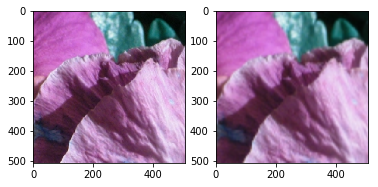

In [ ]:
# degrade the image
image_i = 0

fig = plt.figure()
fig.add_subplot(1,2,1)
# original image
plt.imshow(img_o[0])
# degraded image
fig.add_subplot(1,2,2)
plt.imshow(img[0])

### Building the model

In [ ]:
def make_model():
  SRCNN = Sequential()
  SRCNN.add(Conv2D(filters=128,kernel_size=(9,9),kernel_initializer='glorot_uniform',
                  activation='relu',padding='valid',use_bias=True,input_shape=(None,None,3)))
  SRCNN.add(Conv2D(filters=64,kernel_size=(3,3),kernel_initializer='glorot_uniform',
                  activation='relu',padding='same',use_bias=True))
  SRCNN.add(Conv2DTranspose(filters=3,kernel_size=(9,9),kernel_initializer='glorot_uniform',
                  activation='linear',padding='valid',use_bias=True))

  optimizer = Adam(lr=1E-6)
  SRCNN.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mean_squared_error'])
  return SRCNN

##### My attempt to train the model (The model didn't optimize quick enough. Learning rate is too slow)

In [ ]:
img_path = 'gdrive/My Drive/Colab Notebooks/Datasets/SRCNN/Train/*.bmp'
img_o,img = into_matrix(glob.glob(img_path),2)
# define save path
save_path = 'gdrive/My Drive/Colab saves/Image Super Resolution/Try9/'
# define logger callback
logger = CSVLogger(save_path+'log5-22.2.csv',append=True)
# define model checkpoint callback
checkpt = ModelCheckpoint(save_path+'model.{epoch:02d}-{val_loss:.2E}.2.h5',
                          save_best_only=True,
                          monitor='loss',
                          period=50)
# get validation data
val_path = 'gdrive/My Drive/Colab Notebooks/Datasets/SRCNN/Test/Set14/*bmp'
val_o,val = into_matrix(glob.glob(val_path),2)
# Define data augmentation
batch_size = 5


# train the model
model = make_model()
history = model.fit(img/128-1,img_o/128-1,epochs=1000,batch_size=batch_size,
                              verbose=2,
                              validation_data=(val/128-1,val_o/128-1),
                              callbacks=[logger,checkpt])
# model.save(save_path+'5-22.2.h5')

Train on 91 samples, validate on 14 samples
Epoch 1/1000
 - 6s - loss: 0.3004 - mean_squared_error: 0.3004 - val_loss: 0.2902 - val_mean_squared_error: 0.2902
Epoch 2/1000
 - 6s - loss: 0.2943 - mean_squared_error: 0.2943 - val_loss: 0.2844 - val_mean_squared_error: 0.2844
Epoch 3/1000
 - 6s - loss: 0.2882 - mean_squared_error: 0.2882 - val_loss: 0.2789 - val_mean_squared_error: 0.2789
Epoch 4/1000
 - 6s - loss: 0.2823 - mean_squared_error: 0.2823 - val_loss: 0.2734 - val_mean_squared_error: 0.2734
Epoch 5/1000
 - 6s - loss: 0.2764 - mean_squared_error: 0.2764 - val_loss: 0.2680 - val_mean_squared_error: 0.2680
Epoch 6/1000
 - 6s - loss: 0.2707 - mean_squared_error: 0.2707 - val_loss: 0.2629 - val_mean_squared_error: 0.2629
Epoch 7/1000
 - 6s - loss: 0.2651 - mean_squared_error: 0.2651 - val_loss: 0.2580 - val_mean_squared_error: 0.2580
Epoch 8/1000
 - 6s - loss: 0.2596 - mean_squared_error: 0.2596 - val_loss: 0.2529 - val_mean_squared_error: 0.2529
Epoch 9/1000
 - 6s - loss: 0.2541 - 

KeyboardInterrupt: ignored

##### Other attempt. A sanity check. Make sure the model can output the input image (to prove the model capacity). 

In [ ]:
def make_model():
  SRCNN = Sequential()
  SRCNN.add(Conv2D(filters=128,kernel_size=(9,9),kernel_initializer='glorot_uniform',
                  activation='relu',padding='valid',use_bias=True,input_shape=(None,None,3)))
  SRCNN.add(Conv2D(filters=64,kernel_size=(3,3),kernel_initializer='glorot_uniform',
                  activation='relu',padding='same',use_bias=True))
  SRCNN.add(Conv2DTranspose(filters=3,kernel_size=(9,9),kernel_initializer='glorot_uniform',
                  activation='linear',padding='valid',use_bias=True))

  optimizer = Adam(lr=0.0001)
  SRCNN.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mean_squared_error'])
  return SRCNN


# define save path
save_path = 'gdrive/My Drive/Colab saves/Image Super Resolution/Try10/'
# define logger callback
logger = CSVLogger(save_path+'log5-22.2.csv',append=True)
# define model checkpoint callback
checkpt = ModelCheckpoint(save_path+'model.{epoch:02d}-{val_loss:.2E}.2.h5',
                          save_best_only=True,
                          monitor='loss',
                          period=50)
# get validation data
val_path = 'gdrive/My Drive/Colab Notebooks/Datasets/SRCNN/Test/Set14/*bmp'
val_o,val = into_matrix(glob.glob(val_path),2)
# Define data augmentation
batch_size = 5


# train the model
model = make_model()
history = model.fit(img_o/128-1,img_o/128-1,epochs=1000,batch_size=batch_size,
                              verbose=2,
                              validation_data=(val_o/128-1,val_o/128-1),
                              callbacks=[logger,checkpt])

Train on 91 samples, validate on 14 samples
Epoch 1/1000
 - 6s - loss: 0.1505 - mean_squared_error: 0.1505 - val_loss: 0.0523 - val_mean_squared_error: 0.0523
Epoch 2/1000
 - 5s - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 3/1000
 - 5s - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 4/1000
 - 5s - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 5/1000
 - 6s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 6/1000
 - 6s - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 7/1000
 - 6s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 8/1000
 - 6s - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 9/1000
 - 6s - loss: 0.0096 - 

##### Trying to fine tune the trained model which could map input to input to map degraded input to denoised output

In [ ]:
def make_model():
  SRCNN = load_model('gdrive/My Drive/Colab saves/Image Super Resolution/Try10/model.800-5.18E-04.2.h5')
  optimizer = Adam(lr=1E-4)
  SRCNN.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mean_squared_error'])
  return SRCNN


# define save path
save_path = 'gdrive/My Drive/Colab saves/Image Super Resolution/Try11/'
# define logger callback
logger = CSVLogger(save_path+'log5-22.2.csv',append=True)
# define model checkpoint callback
checkpt = ModelCheckpoint(save_path+'model.{epoch:02d}-{val_loss:.2E}.2.h5',
                          save_best_only=True,
                          monitor='loss',
                          period=50)
# load training data
train_path = 'gdrive/My Drive/Colab Notebooks/Datasets/SRCNN/Train/*.bmp'
img_o,img = into_matrix(glob.glob(train_path),2)
# get validation data
val_path = 'gdrive/My Drive/Colab Notebooks/Datasets/SRCNN/Test/Set14/*bmp'
val_o,val = into_matrix(glob.glob(val_path),2)
# Define data augmentation
batch_size = 5
# make a generator to feed the data in
datagen = ImageDataGenerator()
train_gen = datagen.flow(img/128-1,img_o/128-1,batch_size=batch_size)

# train the model
model = make_model()
history = model.fit_generator(train_gen,epochs=1000,
                              steps_per_epoch=len(img)/batch_size,
                              verbose=2,
                              validation_data=(val/128-1,val_o/128-1),
                              callbacks=[logger,checkpt])

Epoch 1/1000
14/14 [==============================] - 6s 442ms/sample - loss: 0.0049 - mean_squared_error: 0.0049
 - 17s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 2/1000
14/14 [==============================] - 1s 59ms/sample - loss: 0.0044 - mean_squared_error: 0.0044
 - 5s - loss: 0.0036 - mean_squared_error: 0.0035 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 3/1000
14/14 [==============================] - 1s 61ms/sample - loss: 0.0044 - mean_squared_error: 0.0044
 - 5s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 4/1000
14/14 [==============================] - 1s 57ms/sample - loss: 0.0043 - mean_squared_error: 0.0043
 - 5s - loss: 0.0030 - mean_squared_error: 0.0031 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 5/1000
14/14 [==============================] - 1s 58ms/sample - loss: 0.0043 - mean_squared_error: 0.0043
 - 5s - loss: 0.0030 - me

##### Evaluating the model
Not bad!

In [ ]:
# load the model from memory
model = load_model('gdrive/My Drive/Colab saves/Image Super Resolution/Try11/model.1000-3.65E-03.2.h5')
# do a prediction on training set
train_pred = model.predict(img/128-1)
# do a prediction on validation set
val_path = 'gdrive/My Drive/Colab Notebooks/Datasets/SRCNN/Test/Set5/*bmp'
val_o,val = into_matrix(glob.glob(val_path),2)
val_pred = model.predict(val/128-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


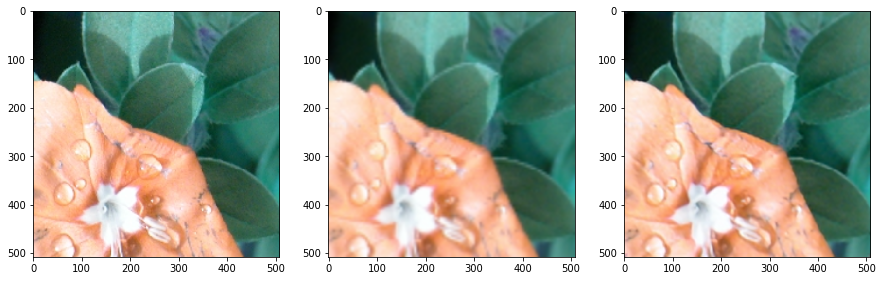

In [ ]:
import matplotlib.pyplot as plt
# visualize the images
# from left to right
# original, degraded, predicted original
i = 6
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,3,1)
plt.imshow(img_o[i])
fig.add_subplot(1,3,2)
plt.imshow(img[i])
fig.add_subplot(1,3,3)
plt.imshow((train_pred[i]+1)*128/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


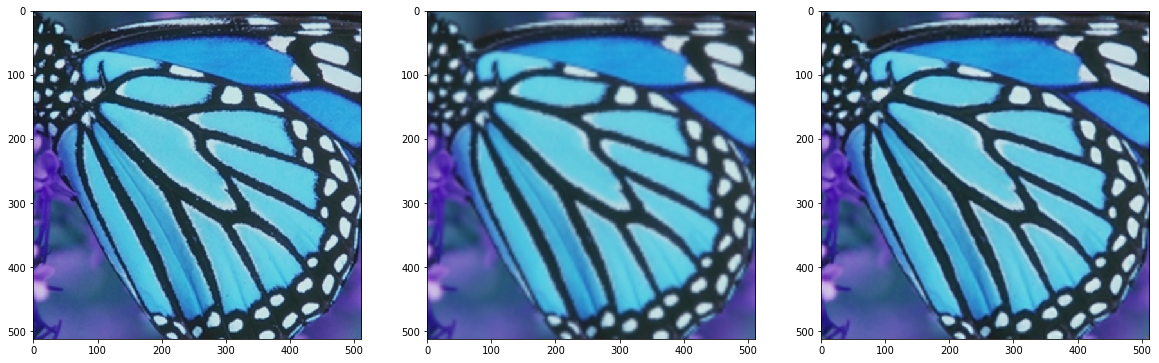

In [ ]:
i = 2
fig = plt.figure(figsize=(20,20))
fig.add_subplot(1,3,1)
plt.imshow(val_o[i])
fig.add_subplot(1,3,2)
plt.imshow(val[i])
fig.add_subplot(1,3,3)
plt.imshow((val_pred[i]+1)*128/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


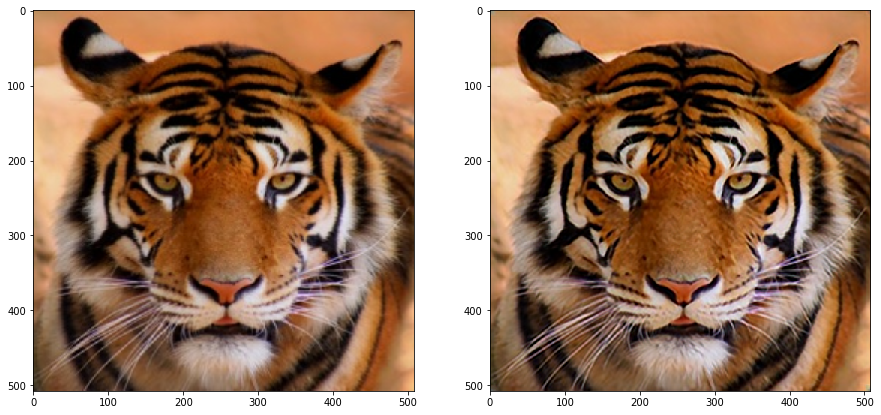

In [ ]:
tiger = cv2.imread('gdrive/My Drive/Colab Notebooks/Datasets/tiger.jpg')
tiger = cv2.resize(tiger,(508,508),interpolation=cv2.INTER_LINEAR)
tiger = cv2.cvtColor(tiger, cv2.COLOR_BGR2RGB)
better_tiger = model.predict(np.array([tiger])/128-1)
fig  = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
plt.imshow(tiger)
fig.add_subplot(1,2,2)
plt.imshow((better_tiger[0]+1)*128/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


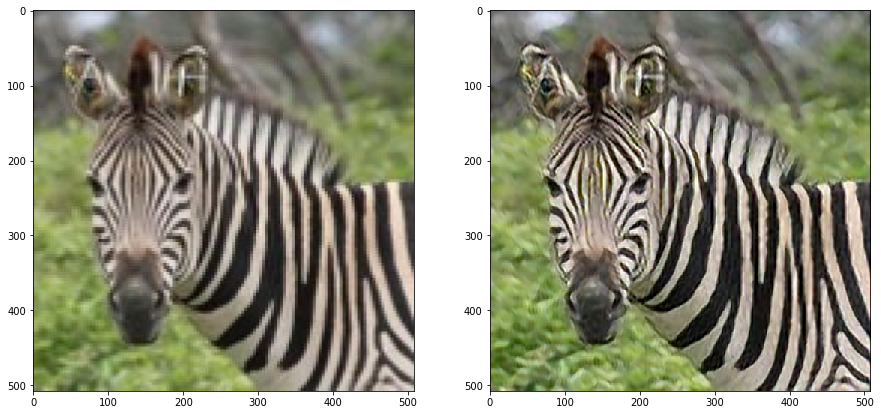

In [ ]:
im = cv2.imread('gdrive/My Drive/Colab Notebooks/Datasets/zebra.jpg')
im = cv2.resize(im,(508,508),interpolation=cv2.INTER_LINEAR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
better_im = model.predict(np.array([im])/128-1)
better_im = model.predict(better_im)


fig  = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
plt.imshow(im)
fig.add_subplot(1,2,2)
plt.imshow((better_im[0]+1)*128/255)

## References:

1) http://mmlab.ie.cuhk.edu.hk/projects/SRCNN/

2) https://www.eduonix.com/learn-machine-learning-by-building-projects

*This notebook loosely followed the tutorial in reference 2